# Multisession registration with CaImAn

This notebook will help to demonstrate how to use CaImAn on movies recorded in multiple sessions. CaImAn has in-built functions that align movies from two or more sessions and try to recognize components that are imaged in some or all of these recordings.

The basic function for this is `caiman.base.rois.register_ROIs()`. It takes two sets of spatial components and finds components present in both using an intersection over union metric and the Hungarian algorithm for optimal matching.
`caiman.base.rois.register_multisession()` takes a list of spatial components, aligns sessions 1 and 2, keeps the union of the matched and unmatched components to register it with session 3 and so on.

In [1]:
import pickle
from caiman.base.rois import register_multisession
from caiman.utils import visualization
from caiman.utils.utils import download_demo
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse import csc_array
import os
from caiman.source_extraction.cnmf.cnmf import load_CNMF
from scipy.signal import welch
from caiman.utils.visualization import get_contours
import time
from caiman.source_extraction.cnmf.deconvolution import GetSn
from caiman.source_extraction.cnmf.utilities import detrend_df_f
import csv

2024-07-31 15:17:07.545219: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
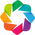

In [2]:
import bokeh.plotting as bpl
import holoviews as hv
bpl.output_notebook()
hv.notebook_extension('bokeh')
from caiman.utils.visualization import inspect_correlation_pnr, nb_inspect_correlation_pnr
import caiman as cm


We provide an example file generated from data courtesy of Sue Ann Koay and David Tank (Princeton University). The file contains the spatial footprints derived from the CNMF analysis of the same FOV over six different days, as well as a template (correlation image) for each day. The `download_demo` command will automatically download the file and store it in your caiman_data folder the first time you run it. To use the demo in your own dataset you can set:

```file_path = '/path/to/file'```

or construct a list of spatial footprints and templates and use that to perform the registration as shown below.

In [3]:
dir01 = '/media/watson/UbuntuHDD/feng_Xin/Xin/Miniscope/newcohort_03242024/sound_discrimination/7277702162024/training_with_miniscope_recordings/day6_training_no_timeout/13_04_50'


data01 = 'output_rescaled_cnmf_save.hdf5'
temp01 = 'output_rescaled.pickle'
tempFile01 = dir01 + os.sep + temp01
dataFile01 = dir01 + os.sep + data01
with open(tempFile01, 'rb') as f:
    template01 = pickle.load(f)
data1 = load_CNMF(dataFile01)

spatial1=data1.estimates.A
spatial_np1 = spatial1.toarray()
idx_1 = data1.estimates.idx_components
spatial_csc1 = csc_array(spatial_np1[:,idx_1],dtype=np.float64)


In [ ]:
# with open('/home/watson/Documents/caiman_fromCluster/51332/day2/'+os.sep+'output_rescaled.pickle','rb') as f:
#     pnr=pickle.load(f)
# nb_inspect_correlation_pnr(pnr[0],pnr[1])

In [ ]:
nb_inspect_correlation_pnr(template01[0],template01[1])

In [ ]:
idx_left = [9, 59, 74,107]
idx_right = [45, 51, 52, 69, 70, 84, 98, 113, 114, 116, 117, 124]

ValueError: dimension mismatch

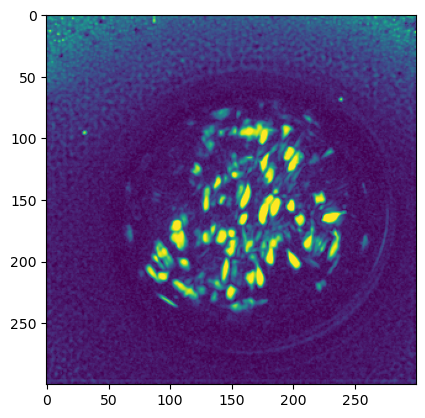

In [6]:
visualization.plot_contours(spatial_np1[:,1], template01[0],colors='k');

In [ ]:
spatial1.shape

In [ ]:
# for i in idx_1:
#     coordinates = get_contours(spatial1[:,i], np.shape(template01[0]), 0.9, thr_method='nrg', swap_dim=False)
#     plt.figure()
#     plt.imshow(template01[0])
#     for c in coordinates:
#         v=c['coordinates']
#         c['bbox'] = [np.floor(np.nanmin(v[:, 1])), np.ceil(np.nanmax(v[:, 1])),
#                          np.floor(np.nanmin(v[:, 0])), np.ceil(np.nanmax(v[:, 0]))]
#         plt.plot(*v.T, c='k')
#         aaa = c['CoM']
#         plt.text(aaa[1],aaa[0],str(i))
#         ccc = c['bbox']
#         print(ccc[1]-ccc[0],ccc[3]-ccc[2])

In [ ]:
data1.estimates.hv_view_components(img=template01[0], idx=data1.estimates.idx_components,
                                denoised_color='red', cmap='gray')

In [ ]:
data1.estimates.hv_view_components(img=template01[0], idx=data1.estimates.idx_components_bad,
                                denoised_color='red', cmap='gray')

In [ ]:
def zscore_trace(denoised_trace, 
                 raw_trace, 
                 offset_method = 'floor', 
                 sn_method='logmexp', 
                 range_ff=[0.25, 0.5]):
    """
    "Z-score" calcium traces based on a calculation of noise from
    power spectral density high frequency.

    Inputs:
        denoised_trace: from estimates.C
        raw_trace: from estimates.C + estimates.YrA
        offset_method: offset to use when shifting the trace (default: 'floor')
            'floor': minimum of the trace so new min will be zero
            'mean': mean of the raw/denoised trace as the zeroing point
            'median': median of raw/denoised trace
            'none': no offset just normalize
        sn_method: how are psd central values caluclated 
            mean
            median' or 'logmexp')
        range_ff: 2-elt array-like range of frequencies (input for GetSn) (default [0.25, 0.5])

    Returns 
        z_denoised: same shape as denoised_trace
        z_raw: same shape as raw trace
        trace_noise: noise level from z_raw
        
    Adapted from code by Zach Barry.
    """
    noise = GetSn(raw_trace, range_ff=range_ff, method=sn_method)  #import this from caiman

    if offset_method == 'floor':
        raw_offset = np.min(raw_trace)
        denoised_offset = np.min(denoised_trace)
    elif offset_method == 'mean':
        raw_offset = np.mean(raw_trace)
        denoised_offset = np.mean(denoised_trace)
    elif offset_method == 'median':
        raw_offset = np.median(raw_trace)
        denoised_offset = np.median(denoised_trace)
    elif offset_method == 'none':
        raw_offset = 0
        denoised_offset = 0
    else:
        raise ValueError("offset_method should be floor, mean, median, or none.")
    print(noise)
    z_raw = (raw_trace - raw_offset) / noise
    z_denoised = (denoised_trace - denoised_offset)/ noise
        
    return z_denoised, z_raw, noise

def zscore_traces(cnm_c, 
                  raw_traces, 
                  offset_method = 'floor', 
                  sn_method = 'logmexp', 
                  range_ff=[0.25, 0.5]):
    """
    apply zscore_trace to all traces in estimates
    
    inputs:
        cnm_c: C array of denoised traces from cnm.estimates
        cnm_yra: YrA array of residuals from cnm.estimate
        offset_method: floor/mean/median (see zscore_trace)
        sn_method: mean/median/logmexp (see zscore_trace)
        range_ff: frequency range for GetSn
    
    outputs:
        denoised_z_traces
        raw_z_traces
        noise_all
    """
    # raw_traces = cnm_c + cnm_yra  # raw_trace[i] = c[i] + yra[i]
    raw_z_traces = []
    denoised_z_traces = []
    noise_all = []
    for ind, raw_trace in enumerate(raw_traces):
        denoised_trace = cnm_c[ind,:]
        z_denoised, z_raw, noise = zscore_trace(denoised_trace,
                                                raw_trace, 
                                                offset_method=offset_method, 
                                                sn_method = sn_method,
                                                range_ff=range_ff)
        
        denoised_z_traces.append(z_denoised)
        raw_z_traces.append(z_raw)
        noise_all.append(noise)
        
    denoised_z_traces = np.array(denoised_z_traces)
    raw_z_traces = np.array(raw_z_traces)
    noise_all = np.array(noise_all)
    
    return denoised_z_traces, raw_z_traces, noise_all

In [ ]:
denoised_traces = data1.estimates.C
residuals = data1.estimates.YrA
raw_traces = denoised_traces+residuals

A = data1.estimates.A
b = data1.estimates.b
C = data1.estimates.C
f = data1.estimates.f
YrA = data1.estimates.YrA

# num_components = denoised_traces.shape[0]
# num_samples = denoised_traces.shape[1]
# frame_rate = data1.params.data['fr']
# sampling_pd = 1/frame_rate
# num_frames = num_samples
# # frame_times = np.arange(0, sampling_pd*num_samples, sampling_pd)
# frame_times = sampling_pd*np.arange(0,num_samples,1)

C_df = detrend_df_f(A, b, C, f, YrA=None, frames_window=500, flag_auto=False, use_fast=False,detrend_only=True,quantileMin=10)


In [ ]:
# C = data1.estimates.C
# YrA = data1.estimates.YrA
# F = C+YrA
# frames_window = 500
# quantileMin = 8

In [ ]:
# from caiman.utils.stats import df_percentile
# data_prct, val = df_percentile(F[:, :frames_window], axis=1)

In [ ]:
# import scipy.ndimage as ndi
# Fd = np.stack([ndi.percentile_filter(
#                     f, prctileMin, (frames_window)) for f, prctileMin in
#                     zip(F, data_prct)])

In [ ]:
# aaa = ndi.percentile_filter(F[30,:],data_prct[30],(frames_window))

In [ ]:
# trace_ind=30
# # compute power spectral density
# raw_trace = raw_traces[trace_ind,:]
# denoised_trace = denoised_traces[trace_ind,:]
# ps_freq, ps_dens = welch(denoised_trace)


# plt.figure(figsize=(10,4))
# plt.semilogy(ps_freq, ps_dens, marker='.', color='k');
# plt.autoscale(enable=True, axis = 'x', tight = True)
# plt.axvspan(0.25, 0.5, color='r', alpha=0.1)
# plt.axvspan(0, 0.25, color='b', alpha=0.1)
# plt.title("Power spectral density")
# plt.xlabel("Frequency (fraction of sampling frequency)")
# plt.ylabel("Power/Hz");


In [ ]:
# z_denoised_floor, z_raw_floor, _ = zscore_trace(denoised_trace, 
#                                                 raw_trace, 
#                                                 offset_method='none', 
#                                                 sn_method='logmexp')
# z_denoised_median, z_raw_median, _ = zscore_trace(denoised_trace, 
#                                                   raw_trace, 
#                                                   offset_method='median', 
#                                                   sn_method='logmexp')

In [ ]:
# f, axes = plt.subplots(2,1, figsize=(12,6))
# axes[0].plot(frame_times, z_denoised_floor)
# axes[0].set_title('Floor', fontsize=14)
# axes[0].grid()
# axes[1].plot(frame_times, z_denoised_median)
# axes[1].set_title('Median', fontsize=14)
# axes[1].grid()

In [ ]:
denoised_z_traces, raw_z_traces, noise_all = zscore_traces(denoised_traces,
                                                           raw_traces, 
                                                           offset_method='floor')

In [ ]:
denoised_z_F_df, raw_z_F_df, noise_all_F_df = zscore_traces(C_df,
                                                           C_df+residuals, 
                                                           offset_method='floor')

In [ ]:
trace_ind=30

In [ ]:
f, axes = plt.subplots(3,1, figsize=(12,6))
axes[0].plot(denoised_z_traces[trace_ind,:])
axes[0].set_title('Floor', fontsize=14)
axes[0].grid()
axes[1].plot(denoised_z_F_df[trace_ind,:])
axes[1].set_title('detrended', fontsize=14)
axes[1].grid()
axes[2].plot(denoised_traces[trace_ind,:])
axes[2].set_title('raw', fontsize=14)
axes[2].grid()

In [ ]:
traces_sz = denoised_z_F_df.shape
with open(dir01 + os.sep + "cellTraces_norm.txt", 'w', newline="\n") as f:
    f_writer = csv.writer(f, delimiter='\t')
    for i in range(traces_sz[0]):
        f_writer.writerow(denoised_z_F_df[i, :])

In [ ]:
# import scipy.ndimage as ndi

# Fd = ndi.percentile_filter(
#                 C, 8, (1, 500))

Now we have the array `traces`, where element `traces[i,j] = k` is the temporal component of neuron `i` at session `j`. This can be performed with `F_dff` data or `S` spikes as well.